We are using two Datasets which contain handwritten digits, described in detail below.
Both datasets are composed of multiple files. Every file contains the different classes for a certain subject. The subject is the person who wrote the digits, the classes are the different characters. 

Conclusion: Each file contains (more or less) the same characters, but written by a different person.

In [ ]:
# clean
#! rm -dr wget
! rm -dr hit
! rm -dr casia
! rm -dr sample_data
! mkdir -p wget
! mkdir -p hit 
! mkdir -p casia

Download HIT dataset

In [ ]:
# Name: HIT (Harbin Institute of Technology)
# Type: Offline database
# Full: Yes
# Classes: 6825
# Subjects: 122
# Total samples: 832650
# Shape: 128x128
# -- HIT_OR3C is a dataset of handwritten Chinese characters.
# -- The 4 subsets of characters contain 6,825 classes produced by 122 subjects and 832,650 samples in total. 
# -- A single file per subject is provided for online data and a single file per subject for offline data.
# -- The individual character images are 128 x 128 greyscale.
! curl "http://www.iapr-tc11.org/dataset/OR3C_DAS2010/v1.1/OR3C/offline/character.rar" -O ./wget/hit_or3c.rar

Extract HIT dataset into subfolder "hit"

In [ ]:
# Extract files into folder 'hit' without the folder structure inside the .rar file
%cd ./hit
! unrar e ../wget/hit_or3c.rar
%cd ..

Download CASIA dataset

In [ ]:
# Name: CASIA (Institute of Automation of Chinese Academy of Sciences)
# Type: Offline database
# Full: No - only HWDB1.0 (about 1/3th of the total dataset)
# Classes: 4037
# Subjects: 420
# Total samples: 1680258
# Shape: ?x? -> not normalized
# -- HWDB1.0 includes 3,866 Chinese characters and 171 alphanumeric and symbols. 
# -- Among the 3,866 Chinese characters, 3,740 characters are in the GB2312-80 level-1 set (which contains 3,755 characters in total).
# -- There are three datasets of isolated characters in the offline handwriting database. 
# -- The datasets include 1,020 files, and each file (*.gnt) stores concatenated gray-scale character images of one writer. 
# -- The file format of *.gnt is specified in Table 2. 
! curl "http://www.nlpr.ia.ac.cn/databases/Download/Offline/CharData/Gnt1.0TrainPart1.zip" -O ./wget/casia1.zip
! curl "http://www.nlpr.ia.ac.cn/databases/Download/Offline/CharData/Gnt1.0TrainPart2.zip" -O ./wget/casia2.zip
! curl "http://www.nlpr.ia.ac.cn/databases/Download/Offline/CharData/Gnt1.0TrainPart3.zip" -O ./wget/casia3.zip
! curl "http://www.nlpr.ia.ac.cn/databases/Download/Offline/CharData/Gnt1.0Test.zip" -O ./wget/casia4.zip  # choose test ourselves

Extract CASIA dataset into subfolder "casia"

In [ ]:
! unzip wget/casia1.zip -d casia
! unzip wget/casia2.zip -d casia
! unzip wget/casia3.zip -d casia
! unzip wget/casia4.zip -d casia

Configuration

Python label dicts to map integer values to their corresponding characters

In [2]:
def parse_label(label):
    result = label
    try:
        test = label[1]  # this will fail for chinese chars
        result = label[0]
    except:
        pass # uses 2 bytes for this char
    return result

In [3]:
import struct
import chardet
import functools

@functools.lru_cache()
def get_label_dict_casia(data_files):
  char_dict = {}
  for data_file in data_files:
    with open(data_file, 'rb') as f:
      while True:
        packed_length = f.read(4)
        if packed_length == b'':
          break
        length = struct.unpack("<I", packed_length)[0]
        raw_label = struct.unpack(">cc", f.read(2))
        width = struct.unpack("<H", f.read(2))[0]
        height = struct.unpack("<H", f.read(2))[0]
        photo_bytes = struct.unpack("{}B".format(height * width), f.read(height * width))
        unencoded_label = raw_label[0] + raw_label[1]
        try:
          label = unencoded_label.decode("GB2312-80")
        except:
          label = unencoded_label.decode(chardet.detect(unencoded_label)["encoding"])
        if label not in char_dict.values():
          char_dict[len(char_dict)] = parse_label(label)
  return char_dict
      
def get_label_dict_hit(label_file):
  char_dict = {}
  with open(label_file, 'r', encoding='GB2312-80') as f:
    label_str = f.read()
    for i in range(len(label_str)):
        char_dict[int(i)] = label_str[i]
  return char_dict


Python generator is iterable and find next image & label on each iteration

In [4]:
import struct
import chardet
import numpy as np

def data_generator_casia(data_files_casia, label_dict, selected=None, transforms=[], return_missing=False):
  for data_file in data_files:
    selected_copy = selected.copy() if selected is not None else label_dict.keys()
    #print(data_file)
    with open(data_file, 'rb') as f:
      while True:
        if len(selected_copy) == 0:
          break
        # print(str(i) + " < " + str(limit))
        skipped = False
        packed_length = f.read(4)
        if packed_length == b'':
          break
        length = struct.unpack("<I", packed_length)[0]
        raw_label = struct.unpack(">cc", f.read(2))
        width = struct.unpack("<H", f.read(2))[0]
        height = struct.unpack("<H", f.read(2))[0]
        photo_bytes = struct.unpack("{}B".format(height * width), f.read(height * width))
        unencoded_label = raw_label[0] + raw_label[1]
        try:
          label = unencoded_label.decode("GB2312-80")
        except:
          label = unencoded_label.decode(chardet.detect(unencoded_label)["encoding"])
        label = parse_label(label)

        if label not in selected_copy:
          continue

        while True:
          popped = selected_copy.pop(0)

          if popped != label:
            # missing value -> return -1 as label with empty image
            if return_missing:
              empty_image = np.zeros([64, 64, 3], dtype=np.uint8)
              empty_image.fill(255)
              yield (empty_image, -1)
          else:
            break

        image = np.array(photo_bytes, dtype='uint8').reshape(height, width)
        for transform in transforms:
          image = transform(image)
        
        key = list(label_dict.values()).index(label)
        yield (image, key)

def data_generator_hit(data_files, label_dict, selected=None, transforms=[], return_missing=False):
  for data_file in data_files:
    selected_copy = selected.copy() if selected is not None else label_dict.keys()
    with open(data_file, 'rb') as f:
      nChars = int(np.fromfile(f, dtype='int32', count=1)[0])
      nCharPixelHeight = int(np.fromfile(f, dtype='uint8', count=1)[0])
      nCharPixelWidth = int(np.fromfile(f, dtype='uint8', count=1)[0])
      range_number = nChars
      for n in range(range_number):
        character = label_dict[n]
        image = np.fromfile(f, dtype='uint8', count=nCharPixelWidth * nCharPixelHeight)
        if len(selected_copy) == 0:
          break
        if character in selected_copy:
          selected_copy.pop(0)
          image = image.reshape(nCharPixelWidth, nCharPixelHeight)
          for transform in transforms:
            image = transform(image)
          yield (image, n)

Define DataProcessor class that is used for easily changing datasets without changing code for model

In [5]:
# DataProcessor : prepares data such that it can be easily used by different models
class DataProcessor:
  ''' Process image data into appropriate format for models, images need to be changed into numpy arrays '''

  def __init__(self, files, data_generator, label_dict, selected, transforms=[], return_missing=False):
    '''
        Args:
            files: List of strings that are paths pointing to dataset files, each file should be in same format
            data_generator: Generator that loads the file and returns a tuple with the next image and label on each iteration
    '''
    self.generator = data_generator(files, label_dict, selected, transforms, return_missing)
    self.label_dict = label_dict

  def get_label_dict(self):
    ''' transform label integer to text with this dictionary '''
    return self.label_dict
  
  def get_data(self):
    ''' returns quadruple in format: (train_images, train_labels, test_images, test_labels) '''
    return self.generator

Create data class that is compatible with both datasets

In [6]:
import glob

def get_data(dataset):

    # Format dataset using our DataProcessor
    data_files_casia = glob.glob('casia/*')
    data_files_hit = glob.glob('hit/*_images')

    # Get parameters based on configuration
    data_files = data_files_casia if dataset == "CASIA" else data_files_hit
    data_generator = data_generator_casia if dataset == "CASIA" else data_generator_hit

    # Get labels
    label_dict = get_label_dict_casia(tuple(data_files_casia)) if dataset == "CASIA" else get_label_dict_hit("hit/labels.txt")

    return data_files, data_generator, label_dict

Create transform function

In [7]:
import cv2

def transform_func(image):

  resize_h, resize_w = (64,64)
  h, w = image.shape

  # resize if too small by adding white area
  top_bottom = int(np.floor((resize_h - h) / 2) if h < resize_h else 0)
  left_right = int(np.ceil((resize_w - w) / 2) if w < resize_w else 0)
  image = cv2.copyMakeBorder(image, top_bottom, top_bottom, left_right, left_right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

  # resize if too large by scaling
  image = cv2.resize(image, (resize_h, resize_w))

  return image

Visualize parts of the dataset

49269
Limited dataset length: 4169
{172, 173, 174, 175, 176, 177, 178, 179, 180, 181}
Limited dataset without missing values length: 4147


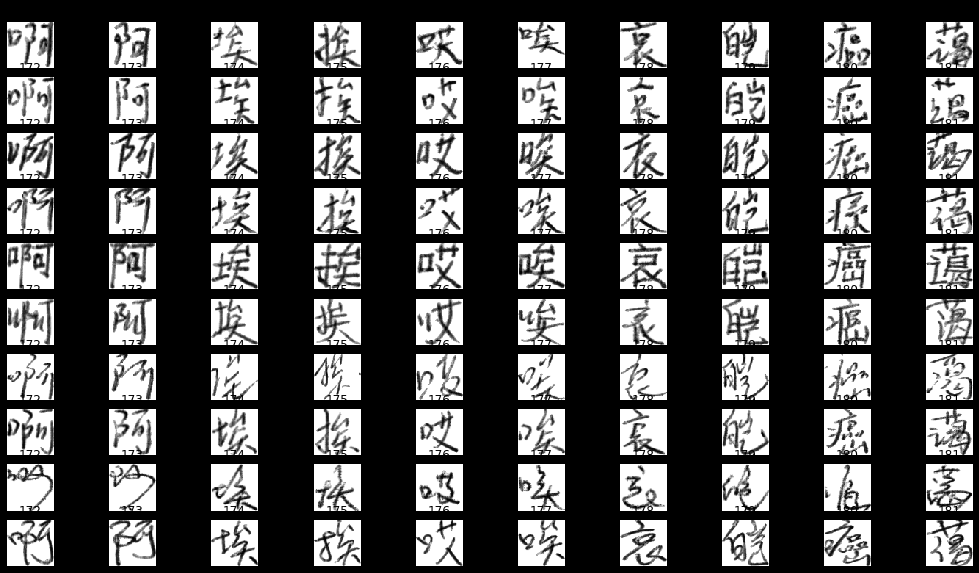

In [8]:
import matplotlib.pyplot as plt 

def explore_data(data_files, data_generator, label_dict, selected, transforms=[], rows=4):

    n_classes = len(selected)
    data_processor = DataProcessor(data_files, data_generator, label_dict, selected, transforms, return_missing=True)
    data_processor_labels = data_processor.get_label_dict()
    data_limited = list(data_processor.get_data())
    print("Limited dataset length: " + str(len(data_limited)))
    num_of_images = n_classes * rows
    f = plt.figure(figsize=(18, rows))
    f.patch.set_facecolor('black')
    for index in range(0, num_of_images):
        subplot = f.add_subplot(rows, n_classes, index + 1)
        subplot.axis('off')
        img, lbl = data_limited[index]
        subplot.title.set_text(lbl)
        subplot.imshow(img.squeeze(), cmap='gray')

    data_limited = [(img, lbl) for img, lbl in data_limited if lbl != -1]
    # TODO: why need < 10 test???????
    print(set([lbl for img, lbl in data_limited]))
    print("Limited dataset without missing values length: " + str(len(data_limited)))

    return data_limited

data_files, data_generator, label_dict = get_data('CASIA')
print(len(label_dict))

selected = list(label_dict.values())[172:182] #62:72 - 172:182
processed_data = explore_data(data_files, data_generator, label_dict, selected, [transform_func], 10)

In [9]:
selected = list(label_dict.values())[62:72]
selected

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [10]:
import matplotlib.pyplot as plt 

def prepare_data(data_files, data_generator, label_dict, selected, transforms=[]):

    data_processor = DataProcessor(data_files, data_generator, label_dict, selected, transforms, return_missing=False)
    data_processor_labels = data_processor.get_label_dict()
    data_limited = list(data_processor.get_data())
    return data_limited

data_files, data_generator, label_dict = get_data('HIT')
print(len(label_dict))
selected = list(label_dict.values())[180:190]
processed_data = prepare_data(data_files, data_generator, label_dict, selected, [transform_func])

6825


Split train and test

In [11]:
from sklearn.model_selection import train_test_split

def split(data_limited):
    images, labels = zip(*data_limited)
    images = np.array([i.flatten() for i in images])
    trainImg, testImg, trainLbl, testLbl = train_test_split(images, labels, test_size=0.25, random_state=22)

    # print("Training size: " + str(len(trainImg)) + ", Test size: " + str(len(testImg)))
    return trainImg, testImg, trainLbl, testLbl 

Helper tool for timing model training and testing

In [12]:
from datetime import datetime

def time_action(action, *args):
  start = datetime.now()
  result = action(*args)
  duration = str((datetime.now() - start).total_seconds())
  duration_str = duration[:duration.index(".") + 3]
  return result, float(duration_str)

Use k-NN to predict class based on the raw pixel intensities

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump, load
import random

def knn(trainImg, trainLbl, testImg, testLbl, n_neighbors=1):

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    nothing, fit_duration = time_action(model.fit, trainImg, trainLbl)
    acc, acc_duration = time_action(model.score, testImg, testLbl)
    print("Finished fit after: {0}s.".format(str(fit_duration)))
    print("Finished score '{0}%' after: {1}s.".format(str(acc),  str(acc_duration)))

    resize_h, resize_w = resize
    prediction_random = random.randint(0, n_classes)
    prediction, prediction_duration = time_action(model.predict, [trainImg[prediction_random]])
    plt.imshow(trainImg[prediction_random].reshape(resize_h, resize_w), cmap="gray")
    print("Finished single prediction '{0}' after: {1}s.".format(label_dict[prediction[0]], str(prediction_duration)))

    dump(model, dataset + '-knn-' + str(n_neighbors) + '.joblib') 

Use SVM to predict class based on raw pixel intensities

In [14]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from joblib import dump, load

def svm(trainImg, trainLbl, testImg, testLbl, kernel='rbf', C=1.0):

    svm = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C))
    nothing, fit_duration = time_action(svm.fit, trainImg, trainLbl)
    acc, acc_duration = time_action(svm.score, testImg, testLbl)

    print("Finished fit after: {0}s.".format(str(fit_duration)))
    print("Finished score '{0}%' after: {1}s.".format(str(acc),  str(acc_duration)))

    resize_h, resize_w = resize
    prediction_random = random.randint(0, n_classes)
    prediction, prediction_duration = time_action(svm.predict, [trainImg[prediction_random]])
    plt.imshow(trainImg[prediction_random].reshape(resize_h, resize_w), cmap="gray")
    print("Finished single prediction '{0}' after: {1}s.".format(label_dict[prediction[0]], str(prediction_duration)))

    dump(svm, dataset + '-svm-' + kernel + '-' + str(C) + '.joblib') 

Use random forest to predict class based on raw pixel intensities

In [15]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import random

def rfc(trainImg, trainLbl, testImg, testLbl, n_jobs=-1, n_estimators=2000):

    rfc = RandomForestClassifier(n_jobs=n_jobs, n_estimators=n_estimators)
    nothing, fit_duration = time_action(rfc.fit, trainImg, trainLbl)
    acc, acc_duration = time_action(rfc.score, testImg, testLbl)
    print("Finished fit after: {0}s.".format(str(fit_duration)))
    print("Finished score '{0}%' after: {1}s.".format(str(acc),  str(acc_duration)))

    resize_h, resize_w = resize
    prediction_random = random.randint(0, n_classes)
    prediction, prediction_duration = time_action(rfc.predict, [trainImg[prediction_random]])
    plt.imshow(trainImg[prediction_random].reshape(resize_h, resize_w), cmap="gray")
    print("Finished single prediction '{0}' after: {1}s.".format(label_dict[prediction[0]], str(prediction_duration)))

    dump(rfc, dataset + '-randomforest-' + str(abs(n_jobs)) + '-' + str(n_estimators) + '.joblib') 

Use neural network prediction based on raw pixel intensities

In [163]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras import backend as K
from joblib import dump, load
import random
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

class ConvNN(BaseEstimator):

    def __init__(self, learning_rate = 0.02, batch_size = 32, n_classes = 3, epochs = 5, verbose=1):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.epochs = epochs
        self.verbose = verbose

        self.img_rows = 64
        self.img_cols = 64
        is_channels_first = K.image_data_format() == 'channels_first'
        self.input_shape = (1, self.img_rows, self.img_cols) 
        if not is_channels_first:
            self.input_shape = (self.img_rows, self.img_cols, 1)

    def fit(self, X, y):

        # input image dimensions
        x_train, x_test, y_train, y_test = train_test_split(X, y)
        
        # 3. "one-hot encoding"
        y_train = keras.utils.to_categorical([x - 62 for x in y_train], self.n_classes)
        y_test = keras.utils.to_categorical([x - 62 for x in y_test], self.n_classes)

        # 4. Define model architecture
        input_shape_ann = (self.img_rows * self.img_cols,)
        self.model = Sequential()
        self.model.name = 'CNN'
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.n_classes, activation='softmax'))

        # 2. Preprocess input data
        x_train = x_train.reshape(x_train.shape[0], *self.input_shape)
        x_test = x_test.reshape(x_test.shape[0], *self.input_shape)
            
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        # x_train /= 255
        # x_test /= 255
        # print('x_train shape:', x_train.shape)
        # print('x_test shape:', x_test.shape)
        # print('y_train shape:', y_train.shape)
        # print('y_test shape:', y_test.shape)
        # print(x_train.shape[0], 'train samples')
        # print(x_test.shape[0], 'test samples')

        # opt = keras.optimizers.Adam(learning_rate=self.learning_rate)
        val_data = (x_test, y_test)
        if self.verbose:
            self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.fit(x_train, y_train, batch_size=self.batch_size, 
                       epochs=self.epochs, verbose=self.verbose, validation_data=val_data)

    def score(self, testImg, testLbl):

        # process data
        testImg =  testImg.reshape(testImg.shape[0], *self.input_shape)
        testImg = testImg.astype('float32')
        testLbl = keras.utils.to_categorical([x - 62 for x in testLbl], self.n_classes)

        # score
        score = self.model.evaluate(testImg, testLbl, verbose=self.verbose)
        # print('Test loss:', str(score[0]))
        # print('Test accuracy:', str(score[1]))
        return score[1]

    def predict(self, testImg):

        # process data
        testImg = np.array(testImg)
        testImg = testImg.reshape(testImg.shape[0], *self.input_shape)
        testImg = testImg.astype('float32')

        # predict
        prediction = self.model.predict(testImg)
        return [p.tolist().index(max(p)) + 62 for p in prediction]
        # print(prediction.shape)
        # return prediction


In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.morphology import skeletonize
from skimage import feature
from skimage.morphology import dilation
from skimage.morphology import square

# preprocessing

def no_preprocessing(images):
    return images

def preprocessed(images):
    images = feature.canny(images, sigma=2) # binarize included
    images = dilation(images, square(2))
    return images

# dimensionality reduction

def no_reduction(images):
    return images

def principal_component_analysis(images):
    images = StandardScaler().fit_transform(images)
    images = PCA(n_components=20).fit_transform(images)
    return images

def triple_loss_embeddings(images):
    return images

In [168]:
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gridSearch = True

param_grid = ParameterGrid({
    'dataset': [['HIT', 62]],  #  ['CASIA', 172]
    'preprocessing': [no_preprocessing, preprocessed],
    'dimensionality_reduction': [no_reduction],  #principal_component_analysis, triple_loss_embeddings
    'classes': [3],  # [3, 10, 50, 100, 200]
    'model': [
        # [lambda n_classes: KNeighborsClassifier(n_neighbors=1), 'knn'], 
        [lambda n_classes: SVC(), 'svc', {}], 
        # [RandomForestClassifier(), 'random_forest'],
        # [lambda n_classes: ConvNN(verbose=0, n_classes=n_classes), 'cnn', {}]
    ]
})
for params in param_grid:

    # print(params)
    dataset_name = params['dataset'][0]
    start = params['dataset'][1]
    end = start + params['classes']
    preprocessing = params['preprocessing']
    dimensionality_reduction = params['dimensionality_reduction']

    # get data
    data_files, data_generator, label_dict = get_data(dataset_name)
    preprocessing_name = str(preprocessing).split(' ')[1]
    dimensionality_reduction_name = str(dimensionality_reduction).split(' ')[1]
    classes = list(label_dict.values())[start:end]
    n_classes = str(len(classes))

    # create model
    model = params['model'][0](int(n_classes))
    model_name = params['model'][1]
    model_params = params['model'][2]

    # prepare data    
    transforms = [transform_func, preprocessing, dimensionality_reduction]
    processed_data = prepare_data(data_files, data_generator, label_dict, classes, transforms)
    trainImg, testImg, trainLbl, testLbl = split(processed_data)
    print(classes)

    # fit
    if gridSearch:
        model = GridSearchCV(model, model_params)
    _, fit_duration = time_action(model.fit, trainImg, trainLbl)
    acc, acc_duration = time_action(model.score, testImg, testLbl)
    # print("-- Finished fit after: {0}s.".format(str(fit_duration)))
    # print("-- Finished score '{0}%' after: {1}s.".format(str(acc),  str(acc_duration)))

    # predict instance
    prediction_random = random.randint(start, end - 1)
    index_of_random_char_in_trainLbl = trainLbl.index(prediction_random)
    random_char = label_dict[prediction_random]
    prediction, prediction_duration = time_action(model.predict, [trainImg[index_of_random_char_in_trainLbl]])
    predicted_char = label_dict[prediction[0]]
    print("-- Predicted '{0}' for '{1}' after: {2}s.".format(predicted_char, random_char, str(prediction_duration)))

    # write summary
    arguments = [dataset_name, preprocessing_name, dimensionality_reduction_name, n_classes, model_name, 
                 acc, fit_duration, acc_duration, prediction_duration]
    print("-- {0} - {1} - {2} - {3} - {4} - {5} - {6} - {7} - {8}".format(*arguments))

    dump(model, params['dataset'][0] + '.joblib')

['啊', '阿', '埃']
-- Predicted '啊' for '啊' after: 0.0s.
-- HIT - no_preprocessing - no_reduction - 3 - svc - 0.9130434782608695 - 2.58 - 0.12 - 0.0
['啊', '阿', '埃']
-- Predicted '埃' for '埃' after: 0.0s.
-- HIT - preprocessed - no_reduction - 3 - svc - 0.9565217391304348 - 2.15 - 0.1 - 0.0


In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

def grid_search(dataset_name, model, param_grid, y_label, x_label, start=62, end=65, return_to_0=True):
    global np

    data_files, data_generator, label_dict = get_data(dataset_name)
    preprocessing_name = str(preprocessing).split(' ')[1]
    dimensionality_reduction_name = str(dimensionality_reduction).split(' ')[1]
    classes = list(label_dict.values())[start:end]
    n_classes = str(len(classes))
    transforms = [transform_func, preprocessing, dimensionality_reduction]
    processed_data = prepare_data(data_files, data_generator, label_dict, classes, transforms)
    X, y = zip(*processed_data)
    X = np.array([i.flatten() for i in X])
    if return_to_0:
        y = np.array([x - start for x in y])
    else:
        y = np.array(y)
    
    param_models = []
    for param_combination in ParameterGrid(param_grid): #
        print(param_combination)
        param_combination = dict(zip(param_combination.keys(), [[v] for v in param_combination.values()]))
        skf = StratifiedKFold(n_splits=3)
        skf.get_n_splits(X, y)
        scores = []
        clf = None
        for train_index, test_index in skf.split(X, y):
            # print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kf, X_test_kf = X[train_index], X[test_index]
            y_train_kf, y_test_kf = y[train_index], y[test_index]
            clf = GridSearchCV(model, param_combination)
            clf.fit(X_train_kf, y_train_kf)
            score = clf.score(X_test_kf, y_test_kf)
            scores.append(score)            
            print('--')
        score = np.mean(scores)
        param_models.append({
            'model': clf,
            'score': score,
            'param': param_combination
        })
        print(str(clf.best_score_) + ' -> ' + str(score))
        print('==')

    # get best model
    best_param_model = [x for x in param_models if x['score'] == max([y['score'] for y in param_models])][0]
    clf = best_param_model['model']
    score = best_param_model['score']
    best_params = best_param_model['param']

    # show scores
    print('scoring')
    print(str(clf.best_score_) + ' -> ' + str(score))
    print(best_params)
    pred = clf.predict(X_test_kf)
    print(classification_report(y_test_kf, pred))

    cols = np.unique(np.array([m['param'][x_label][0] for m in param_models]))
    lr = np.unique(np.array([m['param'][y_label][0] for m in param_models]))
    df = pd.DataFrame()
    df = df.reindex(columns = [round(x, 2) if type(x) == 'float' else x for x in cols])
        
    for i, learning_rate in enumerate(lr):
        vals = [m['score'] for m in param_models if m['param'][y_label][0] == learning_rate]
        df.loc[i] = vals[:9]

    df[y_label] = [round(x, 2) if type(x) == 'float' else x for x in lr]
    df = df.set_index(y_label)
    df = df.sort_values(by=[y_label])
    df_power = df.applymap(lambda x: np.power(x, 20))

    print("--")
    print(df)
    plt.rcParams['image.cmap'] = 'magma'
    plt.rcParams["figure.figsize"] = (8,5)
    plt.pcolor(df_power)
    plt.yticks(np.arange(0.5, len(df_power.index), 1), df_power.index)
    plt.xticks(range(len(df_power.columns)), df_power.columns)
    plt.ylabel(y_label)
    plt.title(x_label)
    plt.show()

    best_param_model = [x for x in param_models if x['score'] == max([y['score'] for y in param_models])][0]
    print(best_param_model['param'])

{'leaf_size': 10, 'n_neighbors': 1}
--
--
--
0.9057377049180328 -> 0.9316939890710382
==
{'leaf_size': 10, 'n_neighbors': 5}
--
--
--
0.9180327868852459 -> 0.9426229508196721
==
{'leaf_size': 10, 'n_neighbors': 10}
--
--
--
0.9139344262295082 -> 0.9398907103825137
==
{'leaf_size': 10, 'n_neighbors': 100}
--
--
--
0.6475409836065573 -> 0.8415300546448087
==
{'leaf_size': 20, 'n_neighbors': 1}
--
--
--
0.9057377049180328 -> 0.9316939890710382
==
{'leaf_size': 20, 'n_neighbors': 5}
--
--
--
0.9180327868852459 -> 0.9426229508196721
==
{'leaf_size': 20, 'n_neighbors': 10}
--
--
--
0.9139344262295082 -> 0.9398907103825137
==
{'leaf_size': 20, 'n_neighbors': 100}
--
--
--
0.6475409836065573 -> 0.8415300546448087
==
{'leaf_size': 50, 'n_neighbors': 1}
--
--
--
0.9057377049180328 -> 0.9316939890710382
==
{'leaf_size': 50, 'n_neighbors': 5}
--
--
--
0.9180327868852459 -> 0.9426229508196721
==
{'leaf_size': 50, 'n_neighbors': 10}
--
--
--
0.9139344262295082 -> 0.9398907103825137
==
{'leaf_size': 

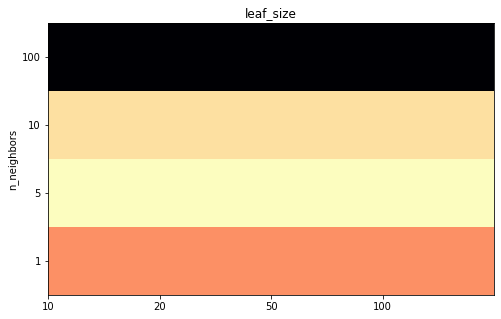

{'leaf_size': [10], 'n_neighbors': [5]}


In [94]:
# KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [1, 5, 10, 100],
    'leaf_size': [10, 20, 50, 100]
}
grid_search('HIT', model, param_grid, 'n_neighbors', 'leaf_size')

{'max_features': 'auto', 'n_estimators': 100}
--
--
--
0.9098360655737705 -> 0.9371584699453551
==
{'max_features': 'auto', 'n_estimators': 200}
--
--
--
0.9262295081967213 -> 0.9289617486338798
==
{'max_features': 'auto', 'n_estimators': 500}
--
--
--
0.9180327868852459 -> 0.9316939890710382
==
{'max_features': 'sqrt', 'n_estimators': 100}
--
--
--
0.9139344262295082 -> 0.9316939890710382
==
{'max_features': 'sqrt', 'n_estimators': 200}
--
--
--
0.9180327868852459 -> 0.9262295081967213
==
{'max_features': 'sqrt', 'n_estimators': 500}
--
--
--
0.930327868852459 -> 0.9398907103825135
==
{'max_features': 'log2', 'n_estimators': 100}
--
--
--
0.930327868852459 -> 0.9316939890710382
==
{'max_features': 'log2', 'n_estimators': 200}
--
--
--
0.9262295081967213 -> 0.9426229508196721
==
{'max_features': 'log2', 'n_estimators': 500}
--
--
--
0.9385245901639344 -> 0.9371584699453552
==
scoring
0.9262295081967213 -> 0.9426229508196721
{'max_features': ['log2'], 'n_estimators': [200]}
            

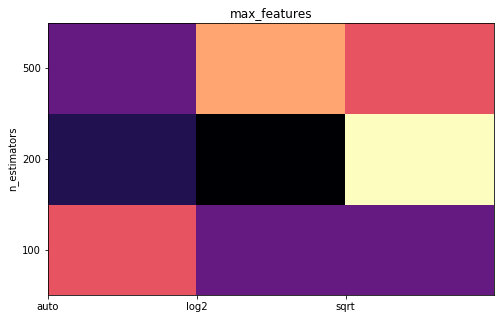

{'max_features': ['log2'], 'n_estimators': [200]}


In [101]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search('HIT', model, param_grid, 'n_estimators', 'max_features')

{'C': 1.0, 'kernel': 'linear'}
--
--
--
0.9508196721311475 -> 0.9480874316939891
==
{'C': 1.0, 'kernel': 'poly'}
--
--
--
0.9385245901639345 -> 0.953551912568306
==
{'C': 1.0, 'kernel': 'rbf'}
--
--
--
0.930327868852459 -> 0.9426229508196723
==
{'C': 1.0, 'kernel': 'sigmoid'}
--
--
--
0.9508196721311475 -> 0.9508196721311476
==
{'C': 2.0, 'kernel': 'linear'}
--
--
--
0.9508196721311475 -> 0.9480874316939891
==
{'C': 2.0, 'kernel': 'poly'}
--
--
--
0.9467213114754098 -> 0.9508196721311476
==
{'C': 2.0, 'kernel': 'rbf'}
--
--
--
0.930327868852459 -> 0.9480874316939891
==
{'C': 2.0, 'kernel': 'sigmoid'}
--
--
--
0.9426229508196722 -> 0.9480874316939891
==
{'C': 4.0, 'kernel': 'linear'}
--
--
--
0.9508196721311475 -> 0.9480874316939891
==
{'C': 4.0, 'kernel': 'poly'}
--
--
--
0.9467213114754098 -> 0.9508196721311476
==
{'C': 4.0, 'kernel': 'rbf'}
--
--
--
0.930327868852459 -> 0.9480874316939891
==
{'C': 4.0, 'kernel': 'sigmoid'}
--
--
--
0.9262295081967213 -> 0.9398907103825137
==
{'C': 8.

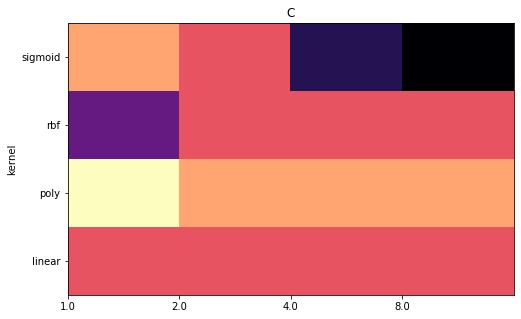

{'C': [1.0], 'kernel': ['poly']}


In [98]:
# SVM

from sklearn.svm import SVC

model = SVC()
param_grid = { 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1.0, 2.0, 4.0, 8.0]
}
grid_search('HIT', model, param_grid, 'kernel', 'C')

In [ ]:
# CNN

import numpy as np

model = ConvNN(verbose=0)
param_grid = { 
    'learning_rate': [0.01, 0.1, 0.5, 1, 2],
    'epochs': [5, 10, 20]
}
grid_search('HIT', model, param_grid, 'kernel', 'C')

{'l2_regularization': 0, 'learning_rate': 0.01, 'max_iter': 5}
--
--
--
0.7172131147540983 -> 0.8032786885245903
==
{'l2_regularization': 0, 'learning_rate': 0.1, 'max_iter': 5}
--
--
--
0.7950819672131147 -> 0.8415300546448087
==
{'l2_regularization': 0, 'learning_rate': 0.5, 'max_iter': 5}
--
--
--
0.8401639344262295 -> 0.8743169398907105
==
{'l2_regularization': 0, 'learning_rate': 1, 'max_iter': 5}
--
--
--
0.8565573770491803 -> 0.8743169398907105
==
{'l2_regularization': 0, 'learning_rate': 5, 'max_iter': 5}
--
--
--
0.38114754098360654 -> 0.33060109289617484
==
{'l2_regularization': 1, 'learning_rate': 0.01, 'max_iter': 5}
--
--
--
0.7213114754098361 -> 0.7923497267759564
==
{'l2_regularization': 1, 'learning_rate': 0.1, 'max_iter': 5}
--
--
--
0.7663934426229508 -> 0.8524590163934427
==
{'l2_regularization': 1, 'learning_rate': 0.5, 'max_iter': 5}
--
--
--
0.8114754098360656 -> 0.8852459016393442
==
{'l2_regularization': 1, 'learning_rate': 1, 'max_iter': 5}
--
--
--
0.774590163

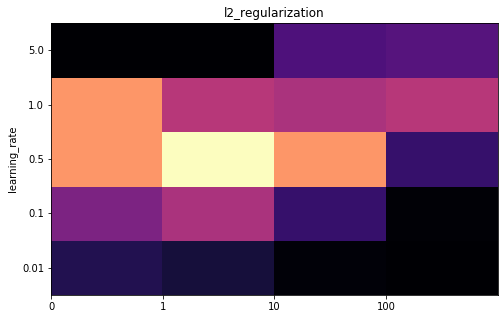

{'l2_regularization': [1], 'learning_rate': [0.5], 'max_iter': [5]}


In [99]:
# HistGradientBoostingClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier()
param_grid = {
    'max_iter': [5],
    'learning_rate': [0.01, 0.1, 0.5, 1, 5],
    'l2_regularization': [0, 1, 10, 100]
}
grid_search('HIT', model, param_grid, 'learning_rate', 'l2_regularization')

{'epochs': 1, 'learning_rate': 0.1, 'n_classes': 3}
--
--
--
0.7653911471366882 -> 0.8989071051279703
==
{'epochs': 1, 'learning_rate': 0.5, 'n_classes': 3}
--
--
--
0.8482142806053161 -> 0.9016393423080444
==
{'epochs': 1, 'learning_rate': 1, 'n_classes': 3}
--
--
--
0.7666666746139527 -> 0.8797814249992371
==
{'epochs': 2, 'learning_rate': 0.1, 'n_classes': 3}
--
--
--
0.9016156435012818 -> 0.8852458993593851
==
{'epochs': 2, 'learning_rate': 0.5, 'n_classes': 3}
--
--
--
0.8199830055236816 -> 0.9426229596138
==
{'epochs': 2, 'learning_rate': 1, 'n_classes': 3}
--
--
--
0.8976190567016602 -> 0.939890722433726
==
{'epochs': 3, 'learning_rate': 0.1, 'n_classes': 3}
--
--
--
0.9301870822906494 -> 0.9453551967938741
==
{'epochs': 3, 'learning_rate': 0.5, 'n_classes': 3}
--
--
--
0.9137755155563354 -> 0.9453551769256592
==
{'epochs': 3, 'learning_rate': 1, 'n_classes': 3}
--
--
--
0.9301870822906494 -> 0.9453551967938741
==
scoring
0.9301870822906494 -> 0.9453551967938741
{'epochs': [3], 

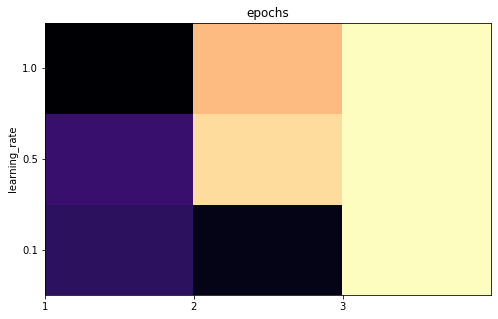

{'epochs': [3], 'learning_rate': [0.1], 'n_classes': [3]}


In [174]:
# CNN

model = ConvNN(verbose=0, n_classes=3)
param_grid = { 
    'learning_rate': [0.1, 0.5, 1],
    'epochs': [1, 2, 3]
}
grid_search('HIT', model, param_grid, 'learning_rate', 'epochs', return_to_0=False)